In [1]:
!pip -q install textstat rouge_score bert_score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 52.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive
import os, pandas as pd

# montar disco
drive.mount('/content/drive')
# Path del proyecto
PATH='/content/drive/MyDrive/iso4simplify'
os.chdir(PATH)


Mounted at /content/drive


In [3]:
import numpy as np
SEED = 42
np.random.seed(SEED)


In [24]:
# Escribe los nombres de tus columnas
COL_ID='pair_id'
COL_COMPLEX='complex'   # texto original
COL_REF='simple'        # texto simplificado
# Nombre del dataset
DATASET='tsar2024'

DIR_DATASET=f'data/{DATASET}/'
LANG='en'

OUT_DIR = DIR_DATASET

In [26]:
PATH_FILE = DIR_DATASET+f'{DATASET}_test.csv'

df = pd.read_csv(PATH_FILE)
print(df.shape)
df=df[[COL_ID, COL_COMPLEX, COL_REF ]]
print(df.columns)
display(df.head(1))
print('='*50)

(117, 10)
Index(['pair_id', 'complex', 'simple'], dtype='object')


,pair_id,complex,simple
0,CD001096,Twenty-eight studies (reporting a total of thi...,The reminders improved physician practices by ...


In [27]:
import re
import spacy
def norm_ws(s: str) -> str:
    return re.sub(r"\s+", " ", str(s)).strip()

# Quitamos espacios en blanco
df[COL_COMPLEX] = df[COL_COMPLEX].map(norm_ws)
df[COL_REF]  = df[COL_REF].map(norm_ws)

# spaCy (tokenization + sentence splitting)
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser", "tagger", "lemmatizer"])
# Para tener oraciones sin parser:
if "sentencizer" not in nlp.pipe_names:
    nlp.add_pipe("sentencizer")


In [28]:
from tqdm.auto import tqdm

def tokens_lower(text):
    doc = nlp(text)
    return [t.text.lower() for t in doc if (not t.is_space) and (t.is_alpha)]

def sent_count(text):
    doc = nlp(text)
    return len(list(doc.sents))

def word_count(text):
    return len(tokens_lower(text))

def jaccard(setA, setB):
    if not setA and not setB:
        return np.nan
    return len(setA & setB) / max(1, len(setA | setB))

# 5) Row-level features
tqdm.pandas()

# número de palabras y oraciones en los textos complejos
df["c_words"] = df[COL_COMPLEX].progress_map(word_count)
df["s_words"] = df[COL_REF].progress_map(word_count)
# número de palabras y oraciones en los textos simplificados

df["c_sents"] = df[COL_COMPLEX].progress_map(sent_count)
df["s_sents"] = df[COL_REF].progress_map(sent_count)

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

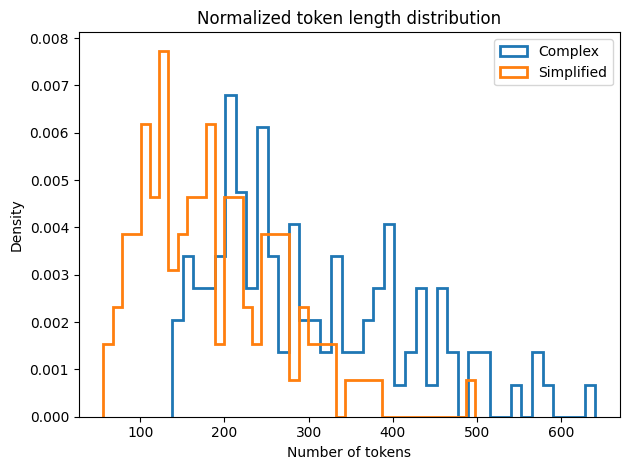

In [29]:
import matplotlib.pyplot as plt
plt.figure()

plt.hist(df["c_words"].dropna(), bins=40, density=True, histtype='step', linewidth=2, label="Complex")
plt.hist(df["s_words"].dropna(), bins=40, density=True, histtype='step', linewidth=2, label="Simplified")

plt.xlabel("Number of tokens")
plt.ylabel("Density")
plt.title("Normalized token length distribution")
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
# Compute the ratio of simplified text length to original text length
# (values <1 mean shorter, >1 mean longer).
df["word_ratio_s_over_c"] = df["s_words"] / df["c_words"].replace(0, np.nan)
# Sentence count ratio (simple/original); <1 means fewer sentences, >1 means more sentences.
df["sent_ratio_s_over_c"] = df["s_sents"] / df["c_sents"].replace(0, np.nan)
# Word count difference (simple - original); negative = shorter, positive = longer.
df["delta_words"] = df["s_words"] - df["c_words"]
# Sentence count difference (simple - original); negative = fewer sentences, positive = more sentences.
df["delta_sents"] = df["s_sents"] - df["c_sents"]

In [31]:
# lexical overlap (jaccard on lowercased word sets)
df["c_set"] = df[COL_COMPLEX].progress_map(lambda x: set(tokens_lower(x)))
df["s_set"] = df[COL_REF].progress_map(lambda x: set(tokens_lower(x)))
df["jaccard_lex"] = df.apply(lambda r: jaccard(r["c_set"], r["s_set"]), axis=1)



  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

In [32]:
import textstat
# readability (English)
def safe_metric(fn, text):
    text = norm_ws(text)
    if not text:
        return np.nan
    try:
        return fn(text)
    except Exception:
        return np.nan

df["c_fkgl"] = df[COL_COMPLEX].map(lambda t: safe_metric(textstat.flesch_kincaid_grade, t))
df["s_fkgl"] = df[COL_REF].map(lambda t: safe_metric(textstat.flesch_kincaid_grade, t))
df["c_fre"]  = df[COL_COMPLEX].map(lambda t: safe_metric(textstat.flesch_reading_ease, t))
df["s_fre"]  = df[COL_REF].map(lambda t: safe_metric(textstat.flesch_reading_ease, t))
df["delta_fkgl"] = df["s_fkgl"] - df["c_fkgl"]
df["delta_fre"]  = df["s_fre"]  - df["c_fre"]

In [33]:
from rouge_score import rouge_scorer

# 6) ROUGE-L (simple vs complex): overlap proxy
scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)
rougeL = []
for s, c in zip(df[COL_REF].tolist(), df[COL_COMPLEX].tolist()):
    rougeL.append(scorer.score(c, s)["rougeL"].fmeasure)  # target=c, prediction=s
df["rougeL_f1"] = rougeL


In [34]:
from bert_score import score as bertscore_score
model_type="xlm-roberta-large"
# =========================
# 5) BERTScore (semántica): simple vs complex
# =========================
# Nota: usa modelo por defecto; puedes fijar uno: model_type="roberta-large" (más pesado).
P, R, F1 = bertscore_score(
    cands=df["simple"].tolist(),
    refs=df["complex"].tolist(),
    lang=LANG,
    model_type=model_type,
    verbose=False
)
df["bertscore_f1"] = F1.numpy()

Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]

XLMRobertaModel LOAD REPORT from: xlm-roberta-large
Key                       | Status     |  | 
--------------------------+------------+--+-
lm_head.dense.weight      | UNEXPECTED |  | 
lm_head.layer_norm.weight | UNEXPECTED |  | 
lm_head.layer_norm.bias   | UNEXPECTED |  | 
lm_head.bias              | UNEXPECTED |  | 
lm_head.dense.bias        | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [35]:
import platform

# 8) Summary helpers
def summarize(series: pd.Series):
    x = pd.to_numeric(series, errors="coerce").dropna().to_numpy()
    if len(x) == 0:
        return {"n": 0}
    return {
        "n": int(len(x)),
        "mean": float(x.mean()),
        "std": float(x.std(ddof=1)) if len(x) > 1 else 0.0,
        "median": float(np.median(x)),
        "p25": float(np.percentile(x, 25)),
        "p75": float(np.percentile(x, 75)),
        "min": float(x.min()),
        "max": float(x.max()),
    }

report = {
    "dataset": {
        "file": PATH_FILE,
        "n_rows": int(len(df)),
        "n_unique_ids": int(df[COL_ID].nunique()),
        "seed": SEED,
    },
    "length_complex": {
        "words": summarize(df["c_words"]),
        "sents": summarize(df["c_sents"]),
    },
    "length_simple": {
        "words": summarize(df["s_words"]),
        "sents": summarize(df["s_sents"]),
    },
    "ratios": {
        "word_ratio_s_over_c": summarize(df["word_ratio_s_over_c"]),
        "sent_ratio_s_over_c": summarize(df["sent_ratio_s_over_c"]),
        "jaccard_lex": summarize(df["jaccard_lex"]),
    },
    "readability": {
        "fkgl_complex": summarize(df["c_fkgl"]),
        "fkgl_simple": summarize(df["s_fkgl"]),
        "delta_fkgl": summarize(df["delta_fkgl"]),
        "fre_complex": summarize(df["c_fre"]),
        "fre_simple": summarize(df["s_fre"]),
        "delta_fre": summarize(df["delta_fre"]),
    },
    "overlap_semantics": {
        "rougeL_f1": summarize(df["rougeL_f1"]),
        "bertscore_f1": summarize(df["bertscore_f1"]),
    },
    "environment": {
        "python": platform.python_version(),
        "platform": platform.platform(),
        "spacy": spacy.__version__,
        "pandas": pd.__version__,
        "numpy": np.__version__,
    }
}

In [36]:
import json
with open(os.path.join(OUT_DIR, f"{DATASET}_report.json"), "w", encoding="utf-8") as f:
    json.dump(report, f, indent=2, ensure_ascii=False)

# 9) Paper table (CSV + LaTeX)
paper_table = pd.DataFrame([
    ["#docs", len(df), "", ""],
    ["Complex words", report["length_complex"]["words"]["mean"], report["length_complex"]["words"]["std"], report["length_complex"]["words"]["median"]],
    ["Simple words",  report["length_simple"]["words"]["mean"],  report["length_simple"]["words"]["std"],  report["length_simple"]["words"]["median"]],
    ["Word ratio (S/C)", report["ratios"]["word_ratio_s_over_c"]["mean"], report["ratios"]["word_ratio_s_over_c"]["std"], report["ratios"]["word_ratio_s_over_c"]["median"]],
    ["Complex sents", report["length_complex"]["sents"]["mean"], report["length_complex"]["sents"]["std"], report["length_complex"]["sents"]["median"]],
    ["Simple sents",  report["length_simple"]["sents"]["mean"],  report["length_simple"]["sents"]["std"],  report["length_simple"]["sents"]["median"]],
    ["Sent ratio (S/C)", report["ratios"]["sent_ratio_s_over_c"]["mean"], report["ratios"]["sent_ratio_s_over_c"]["std"], report["ratios"]["sent_ratio_s_over_c"]["median"]],
    ["FKGL complex", report["readability"]["fkgl_complex"]["mean"], report["readability"]["fkgl_complex"]["std"], report["readability"]["fkgl_complex"]["median"]],
    ["FKGL simple",  report["readability"]["fkgl_simple"]["mean"],  report["readability"]["fkgl_simple"]["std"],  report["readability"]["fkgl_simple"]["median"]],
    ["ΔFKGL (S - C)", report["readability"]["delta_fkgl"]["mean"], report["readability"]["delta_fkgl"]["std"], report["readability"]["delta_fkgl"]["median"]],
    ["FRE complex", report["readability"]["fre_complex"]["mean"], report["readability"]["fre_complex"]["std"], report["readability"]["fre_complex"]["median"]],
    ["FRE simple",  report["readability"]["fre_simple"]["mean"],  report["readability"]["fre_simple"]["std"],  report["readability"]["fre_simple"]["median"]],
    ["ΔFRE (S - C)", report["readability"]["delta_fre"]["mean"], report["readability"]["delta_fre"]["std"], report["readability"]["delta_fre"]["median"]],
    ["Jaccard lex", report["ratios"]["jaccard_lex"]["mean"], report["ratios"]["jaccard_lex"]["std"], report["ratios"]["jaccard_lex"]["median"]],
    ["ROUGE-L F1 (S vs C)", report["overlap_semantics"]["rougeL_f1"]["mean"], report["overlap_semantics"]["rougeL_f1"]["std"], report["overlap_semantics"]["rougeL_f1"]["median"]],
    ["BERTScore F1 (S vs C)", report["overlap_semantics"]["bertscore_f1"]["mean"], report["overlap_semantics"]["bertscore_f1"]["std"], report["overlap_semantics"]["bertscore_f1"]["median"]],
], columns=["Metric", "Mean", "Std", "Median"])

paper_table.to_csv(os.path.join(OUT_DIR, f"{DATASET}_table.csv"), index=False)

with open(os.path.join(OUT_DIR, f"{DATASET}_table.tex"), "w", encoding="utf-8") as f:
    f.write(paper_table.to_latex(index=False, float_format="%.4f"))



In [37]:
# =========================
# 8) Figuras (PNG) para paper
# =========================
def save_hist(series, title, filename, bins=50):
    x = pd.to_numeric(series, errors="coerce").dropna()
    plt.figure()
    plt.hist(x, bins=bins)
    plt.title(title)
    plt.xlabel(title)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, filename), dpi=200)
    plt.close()

save_hist(df["word_ratio_s_over_c"], f"Word ratio (simple/complex) in {DATASET}", f"{DATASET}_hist_word_ratio.png")
save_hist(df["delta_fkgl"], f"Delta FKGL (simple - complex) in {DATASET}", f"{DATASET}_hist_delta_fkgl.png")
save_hist(df["delta_fre"], f"Delta Flesch Reading Ease (simple - complex) in {DATASET}", f"{DATASET}_hist_delta_fre.png")
save_hist(df["jaccard_lex"], f"Jaccard lexical overlap in {DATASET}", f"{DATASET}_hist_jaccard.png")
save_hist(df["bertscore_f1"], f"BERTScore F1 (simple vs complex) in {DATASET}", f"{DATASET}_hist_bertscore.png")

# Figura: scatter cambio longitud vs cambio FKGL
plt.figure()
plt.scatter(df["delta_words"], df["delta_fkgl"])
plt.xlabel("Delta words (simple - complex)")
plt.ylabel("Delta FKGL (simple - complex)")
plt.title(f"Length change vs readability change in {DATASET}")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, f"{DATASET}_scatter_delta_words_vs_delta_fkgl.png"), dpi=200)
plt.close()

In [38]:
# 11) Save enriched CSV
df.drop(columns=["c_set","s_set"], errors="ignore").to_csv(os.path.join(OUT_DIR, f"{DATASET}_test_enriched.csv"), index=False)

print("✅ Done. Outputs saved in:", OUT_DIR)
print("Main files:")
print(f" - {DATASET}_report.json")
print(f" - {DATASET}_table.csv / {DATASET}_table.tex")
print(f" - {DATASET}_test_enriched.csv")
print(f" - figures: {DATASET}_hist_*.png and {DATASET}_scatter_*.png")

✅ Done. Outputs saved in: data/tsar2024/
Main files:
 - tsar2024_report.json
 - tsar2024_table.csv / tsar2024_table.tex
 - tsar2024_test_enriched.csv
 - figures: tsar2024_hist_*.png and tsar2024_scatter_*.png
